In [19]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

instances_size = 'tiny_instances'
results_dir = f'./output/MIPLIB_batch_scalar/test/{instances_size}'
# Read all json files in the results directory
file_names = [f for f in listdir(results_dir) if f.endswith('.json')]
instances = dict()
df_list = []
instances_size=instances_size.replace('_1','')
for file in file_names:
    # if not "k0" in file:
        instance_name = file.split('.')[0]
        with open(f'{results_dir}/{file}', 'r') as f:
            data = json.load(f)

        # data to dataframe
        df = pd.DataFrame(data)

        # change "instance" column to name of file (last after /)
        df['instance'] = df['instance'].apply(lambda x: x.split('/')[-1]).apply(lambda x: x.replace('.mps.gz', ''))
        
        # Time correction: If it has more than 1 row, and the -2 row has value "TERMINATION_REASON_TIME_LIMIT" on column "termination_reason", 
        # then remove the last row
        if len(df) > 1 and df.iloc[-2]['termination_reason'] == 'TERMINATION_REASON_TIME_LIMIT':
            # discount the blackbox_time of last row to the total_time column of every row
            df['total_time'] = df['total_time'] - df.iloc[-1]['blackbox_time']
            df = df.iloc[:-1]

        # KKT: norm of the three "relative" metrics
        df['KKT'] = np.sqrt(df['relative_l_inf_primal_residual']**2 + df['relative_l_inf_dual_residual']**2 + df['relative_optimality_gap']**2)    

        # success: if termination_reason of the last row is "TERMINATION_REASON_OPTIMAL", then success = 1, else 0
        df['success'] = 0
        if df.iloc[-1]['termination_reason'] == 'TERMINATION_REASON_OPTIMAL':
            df.loc[:, 'success'] = 1

        # IR: if 'max_iter' is 0, then it is a IR
        df['IR'] = 0
        if df.iloc[0]['max_iter'] > 0:
            df.loc[:, 'IR'] = 1

        # If it is not a IR, then set alpha to 0
        if df.iloc[0]['max_iter'] == 0:
            df['alpha'] = 0


        # Add the method of calculation of deltas from the name 
        if "median" in file:
            df['method'] = 'median'
        elif "reldiv_2" in file:
            df['method'] = 'reldiv_2'
        elif "reldiv" in file:
            df['method'] = 'reldiv'
        elif "relmult_2" in file:
            df['method'] = 'relmult_2'
        elif "relmult" in file:
            df['method'] = 'relmult'
        else:
            df['method'] = 'other'
        # elif "rel" in file:

        # add to list
        for row in df.iterrows():
            # print(row[2])
            # row = row[1]
            # row series to list
            row = row[1].tolist()
            df_list.append(pd.DataFrame([row], columns=df.columns))

# Concatenate all dataframes
df = pd.concat(df_list)
# Change column names
col_names_dict = {
    'last_iteration': 'k_iters',
    'total_time': 'time',
    'D1_condition_number': 'D1_maxcn',
    'D2_condition_number': 'D2_maxcn',
}
df.rename(columns=col_names_dict, inplace=True)

# display(df.sample(10))
# Sort by instance, alpha and max_iter
# df.sort_values(by=['instance'], inplace=True)
# Group by instance, alpha and max_iter
grouped = df.groupby(['instance', 'IR', 'alpha', 'method'])
# columns to get the min value
tail_cols = ['KKT', 'success', 'time', 'k_iters']
# columns to get the max value
max_cols = ['D1_maxcn', 'D2_maxcn']
grouped = grouped.agg({**{col: 'min' for col in tail_cols}, **{col: 'max' for col in max_cols}})

# Round to 3 decimals time, and condition numbers columns
# grouped['time'] = grouped['time'].apply(lambda x: round(x, 3))
# grouped['D1_maxcn'] = grouped['D1_maxcn'].apply(lambda x: round(x, 3))
# grouped['D2_maxcn'] = grouped['D2_maxcn'].apply(lambda x: round(x, 3))

i0 = 40
display(grouped.iloc[i0:i0+21,:])

# display only rows with instance = 'ns1456591'
# display(grouped.loc['blp-ic98'])


# Save grouped dataframe to csv
# grouped.to_csv(f'MIPLIB_output/batch_output/{instances_size}_600.csv')


KKT  success        time  k_iters  \
instance    IR alpha   method                                               
neos-933638 0  0.0     other   9.889888e-09        1    1.816970        0   
            1  100.0   other   1.165247e-09        1    3.477708        1   
               1000.0  other   2.055904e-09        1    3.773361        1   
               10000.0 other   2.055904e-09        1    3.766258        1   
neos-933966 0  0.0     other   3.999957e-09        1    1.763372        0   
            1  100.0   other   1.478210e-10        1    4.382959        1   
               1000.0  other   1.499780e-10        1    3.730310        1   
               10000.0 other   1.304537e-10        1    3.852643        1   
neos-960392 0  0.0     other   1.148412e-08        1    5.344906        0   
            1  100.0   other   2.165576e-13        1   14.485051        2   
               1000.0  other   3.004554e-14        1   16.184617        2   
               10000.0 other   7.542356e-13        0  600.510956        2   
ns1430538   0  0.0     other   1.403119e-08        1   33.679477        0   
ns1456591   0  0.0     other   3.929353e-09        1   23.075337        0   
            1  100.0   other   3.282864e-11        1   19.232203        1   
               1000.0  other   5.138178e-12        1   13.904474        1   
               10000.0 other   2.898718e-12        1   13.741806        1   
ns1828997   0  0.0     other   1.047842e-09        1    2.791457        0   
            1  100.0   other   1.147059e-13        1    8.842242        2   
               1000.0  other   6.358169e-10        1    5.614380        1   
               10000.0 other   9.457067e-12        1    5.788257        1   

                                    D1_maxcn      D2_maxcn  
instance    IR alpha   method                               
neos-933638 0  0.0     other        1.000000  1.000000e+00  
            1  100.0   other      100.000000  8.176573e+01  
               1000.0  other      157.722251  8.176573e+01  
               10000.0 other      157.722251  8.176573e+01  
neos-933966 0  0.0     other        1.000000  1.000000e+00  
            1  100.0   other      100.000000  1.000000e+02  
               1000.0  other     1000.000000  7.111713e+02  
               10000.0 other     1110.406109  7.111713e+02  
neos-960392 0  0.0     other        1.000000  1.000000e+00  
            1  100.0   other     2308.700564  1.000000e+04  
               1000.0  other    23087.005640  2.936426e+05  
               10000.0 other   230870.056399  2.936426e+06  
ns1430538   0  0.0     other        1.000000  1.000000e+00  
ns1456591   0  0.0     other        1.000000  1.000000e+00  
            1  100.0   other      100.000000  1.000000e+02  
               1000.0  other      133.887101  1.000000e+03  
               10000.0 other      133.887101  1.000000e+04  
ns1828997   0  0.0     other        1.000000  1.000000e+00  
            1  100.0   other    10000.000000  1.000000e+04  
               1000.0  other     1000.000000  1.000000e+03  
               10000.0 other    10000.000000  1.000000e+04

### House problem plots

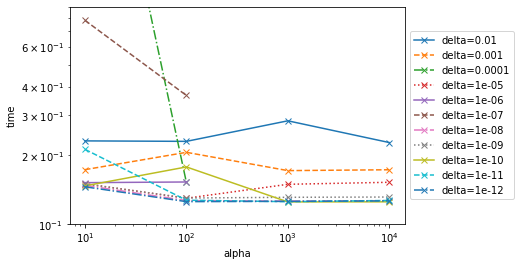

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

instances_size = 'house_instances'
results_dir = f'./output/mps1/{instances_size}'
# Read all json files in the results directory
file_names = [f for f in listdir(results_dir) if f.endswith('.json')]
instances = dict()
df_list = []
# instances_size=instances_size.replace('_1','')
for file in file_names:
    # if not "k0" in file:
        instance_name = file.split('.mps')[0]
        with open(f'{results_dir}/{file}', 'r') as f:
            data = json.load(f)

        # data to dataframe
        df = pd.DataFrame(data)

        # change "instance" column to name of file (last after /)
        df['instance'] = df['instance'].apply(lambda x: x.split('/')[-1]).apply(lambda x: x.replace('.mps', ''))
        
        # Time correction: If it has more than 1 row, and the -2 row has value "TERMINATION_REASON_TIME_LIMIT" on column "termination_reason", 
        # then remove the last row
        if len(df) > 1 and df.iloc[-2]['termination_reason'] == 'TERMINATION_REASON_TIME_LIMIT':
            # discount the blackbox_time of last row to the total_time column of every row
            df['total_time'] = df['total_time'] - df.iloc[-1]['blackbox_time']
            df = df.iloc[:-1]

        # KKT: norm of the three "relative" metrics
        df['KKT'] = np.sqrt(df['relative_l_inf_primal_residual']**2 + df['relative_l_inf_dual_residual']**2 + df['relative_optimality_gap']**2)    

        # success: if termination_reason of the last row is "TERMINATION_REASON_OPTIMAL", then success = 1, else 0
        df['success'] = 0
        if df.iloc[-1]['termination_reason'] == 'TERMINATION_REASON_OPTIMAL':
            df.loc[:, 'success'] = 1

        # IR: if 'max_iter' is 0, then it is a IR
        df['IR'] = 0
        if df.iloc[0]['max_iter'] > 0:
            df.loc[:, 'IR'] = 1

        # If it is not a IR, then set alpha to 0
        if df.iloc[0]['max_iter'] == 0:
            df['alpha'] = 0


        # Add the method of calculation of deltas from the name 
        if "median" in file:
            df['method'] = 'median'
        elif "reldiv_2" in file:
            df['method'] = 'reldiv_2'
        elif "reldiv" in file:
            df['method'] = 'reldiv'
        elif "relmult_2" in file:
            df['method'] = 'relmult_2'
        elif "relmult" in file:
            df['method'] = 'relmult'
        else:
            df['method'] = 'other'
        # elif "rel" in file:

        # Add the delta of housing problem
        # print(instance_name)
        delta = float(instance_name.replace('house_k5_d',''))
        if delta == 0.1:
            continue
        # Save delta in the dataframe, but change format to scientific notation
        df['delta'] = delta
        # df['delta'] = df['delta'].apply(lambda x: '{:.1e}'.format(x))

        # add to list
        for row in df.iterrows():
            # print(row[2])
            # row = row[1]
            # row series to list
            row = row[1].tolist()
            df_list.append(pd.DataFrame([row], columns=df.columns))

# Concatenate all dataframes
df = pd.concat(df_list)
# Change column names
col_names_dict = {
    'last_iteration': 'k_iters',
    'total_time': 'time',
    'D1_condition_number': 'D1_maxcn',
    'D2_condition_number': 'D2_maxcn',
}
df.rename(columns=col_names_dict, inplace=True)

# display(df.sample(10))
# Sort by instance, alpha and max_iter
# df.sort_values(by=['instance'], inplace=True)
# Group by instance, alpha and max_iter
grouped = df.groupby(['delta','instance', 'IR', 'alpha'])
# columns to get the min value
tail_cols = ['KKT', 'success', 'time', 'k_iters']
# columns to get the max value
max_cols = ['D1_maxcn', 'D2_maxcn']
grouped = grouped.agg({**{col: 'min' for col in tail_cols}, **{col: 'max' for col in max_cols}})


# Sorty by delta
grouped = grouped.sort_values(by=['delta'], ascending=False)
# Round to 3 decimals time, and condition numbers columns
# grouped['time'] = grouped['time'].apply(lambda x: round(x, 3))
# grouped['D1_maxcn'] = grouped['D1_maxcn'].apply(lambda x: round(x, 3))
# grouped['D2_maxcn'] = grouped['D2_maxcn'].apply(lambda x: round(x, 3))

# i0 = 15
# display(grouped.iloc[i0:i0+21,:])


# Plot the time of the instances in terms of alpha
ax, fig = plt.subplots()
grouped = grouped.reset_index()

# Split the dataframe by k_iters
grouped_k1 = grouped[grouped['k_iters'] == 1]
grouped_k0 = grouped[grouped['k_iters'] == 0]

line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
for i,delta in enumerate(grouped_k1['delta'].unique()):
    # for alpha in grouped_k1['alpha'].unique():
        # df_plot = grouped_k1[(grouped_k1['delta'] == delta) & (grouped_k1['alpha'] == alpha)]
    df_plot = grouped_k1[(grouped_k1['delta'] == delta)]

    if delta < 0.1 and delta > 0.001:
        delta = round(delta, 3)

    # Sort by alpha
    df_plot = df_plot.sort_values(by=['alpha'], ascending=True)

    # Plot time vs alpha, with log(alpha)
    plt.plot(df_plot['alpha'], df_plot['time'], label=f'delta={delta}', linestyle=line_styles[i], marker='x')
    # double log scale for y
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('time')

# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend()
plt.ylim(1e-1, 0.9)
plt.show()


    # plt.plot(df_plot['alpha'], df_plot['time'], label=f'delta={delta}, alpha={alpha}')

# Save grouped_k1 dataframe to csv
# grouped.to_csv(f'MIPLIB_output/batch_output/{instances_size}_600.csv')


c:\Users\niace\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,delta,instance,IR,alpha,KKT,success,time,k_iters,D1_maxcn,D2_maxcn
4,1.000000e-02,house_k5_d0.010000000000000002,0,0.01,2.867510e-11,1,18.473639,0,1.0,1.0
9,1.000000e-03,house_k5_d0.001,0,0.00,1.354117e-15,1,0.257789,0,1.0,1.0
24,1.000000e-07,house_k5_d1.0e-7,0,0.00,NaN,0,616.749320,0,1.0,1.0
28,1.000000e-08,house_k5_d1.0e-8,0,0.00,1.350045e-09,1,18.349054,0,1.0,1.0
34,1.000000e-09,house_k5_d1.0e-9,0,0.00,1.350046e-10,1,18.486040,0,1.0,1.0
37,1.000000e-10,house_k5_d1.0e-10,0,0.00,1.350031e-11,1,0.019463,0,1.0,1.0
44,1.000000e-11,house_k5_d1.0e-11,0,0.00,1.349747e-12,1,0.019666,0,1.0,1.0
49,1.000000e-12,house_k5_d1.0e-12,0,0.00,1.349706e-13,1,0.019339,0,1.0,1.0


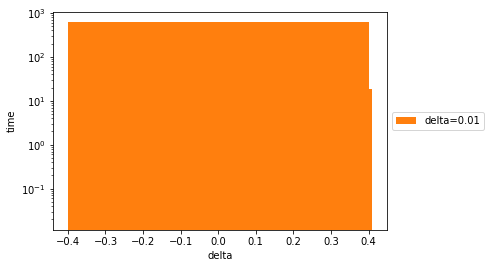

In [57]:

line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']

grouped_k0.loc[grouped_k0['delta'] ==0.010000000000000002, 'alpha'] = 0.01

# # for i,delta in enumerate(grouped_k0['delta'].unique()):
#     # for alpha in grouped_k0['alpha'].unique():
#         # df_plot = grouped_k0[(grouped_k0['delta'] == delta) & (grouped_k0['alpha'] == alpha)]
#     df_plot = grouped_k0[(grouped_k0['delta'] == delta)]

#     if delta < 0.1 and delta > 0.001:
df_plot = grouped_k0
display(df_plot)
# Sort by alpha
df_plot = df_plot.sort_values(by=['alpha'], ascending=True)

# Plot time vs alpha, with log(alpha)
# uniform spaced barplot of time vs delta
plt.bar(df_plot['alpha'], df_plot['time'])
plt.bar(df_plot['delta'], df_plot['time'], label=f'delta={delta}')
# double log scale for y
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('delta')
plt.ylabel('time')

# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend()
# plt.ylim(1e-1, 0.9)
plt.show()



In [77]:
import numpy as np

# Generate a randon normal vector of mean 0 and std 1
x = np.random.normal(0, 1, 100) +10

# Print the vector
# print(x)

# Get the average of the vector, the std and the geometric mean
mean = np.mean(x)
std = np.std(x)
# Print the results
print(f"Mean: {mean}")
print(f"Std: {std}")
for delta in [10]:
    sgm = np.prod(x+ delta)**(1/len(x)) - delta
    print(f"SGM: {sgm}")
# gmean = np.exp(np.mean(np.log(np.abs(x))))


# print(f"Geometric mean: {gmean}")

Mean: 9.655670909939364
Std: 1.0099906141214892
SGM: 9.629649919256291


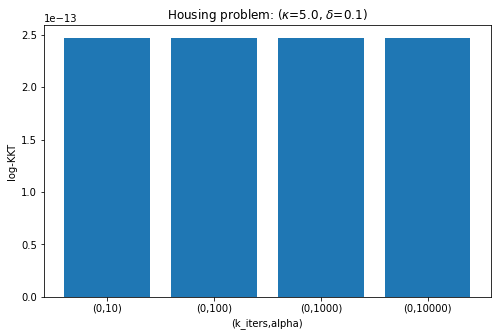

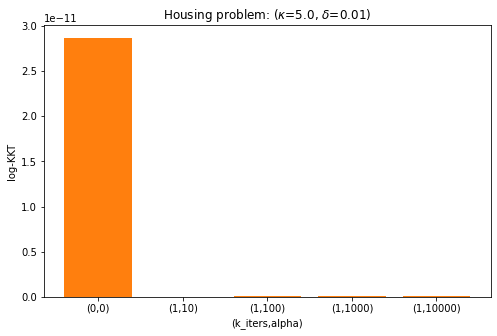

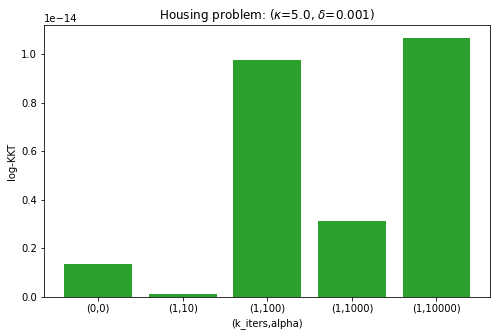

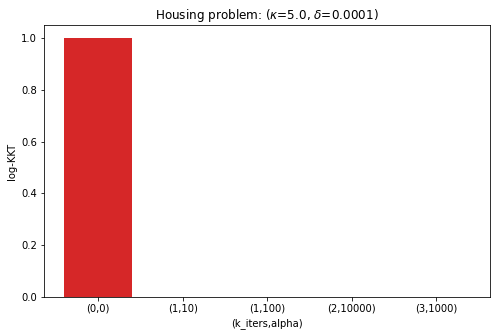

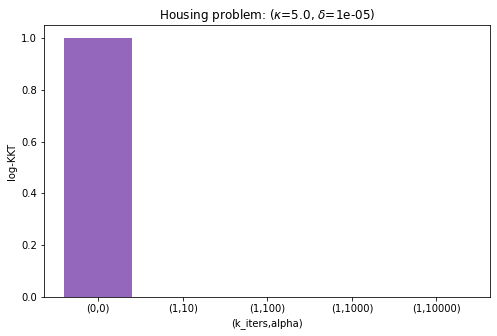

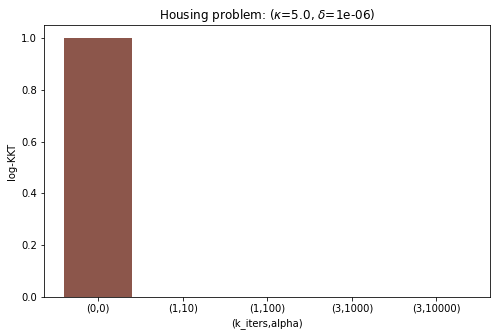

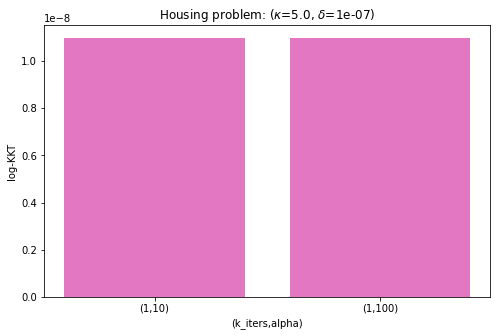

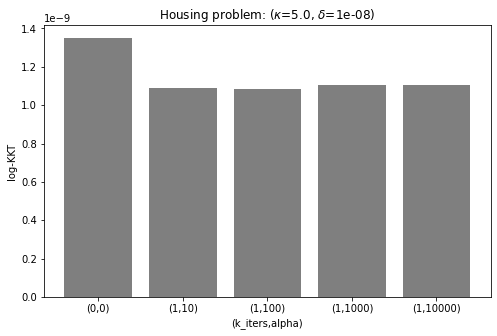

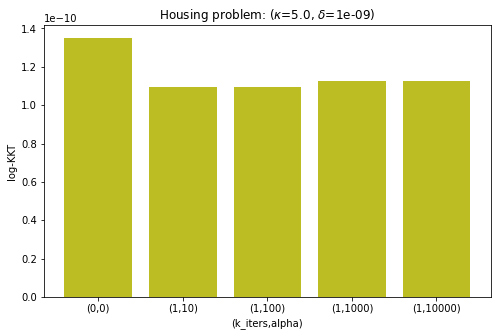

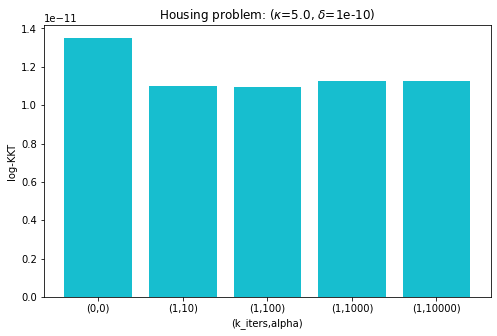

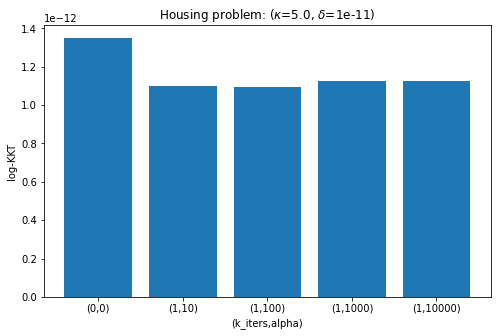

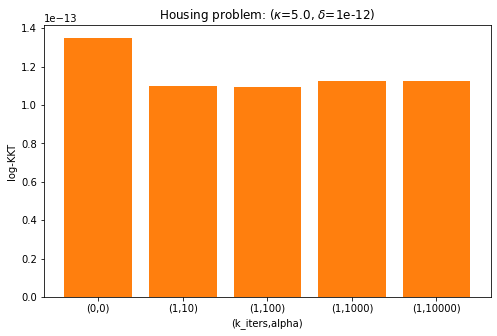

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

instances_size = 'house_instances'
results_dir = f'./output/mps1/{instances_size}'
# Read all json files in the results directory
file_names = [f for f in listdir(results_dir) if f.endswith('.json')]
instances = dict()
df_list = []
# instances_size=instances_size.replace('_1','')
for file in file_names:
    # if not "k0" in file:
        instance_name = file.split('.mps')[0]
        kappa = float(instance_name.split('_')[1].replace('k',''))
        delta = float(instance_name.split('_')[2].replace('d',''))
        if delta == 0.010000000000000002:
            delta = 0.01
        # print(instance_name, kappa, delta)
        # continue
        with open(f'{results_dir}/{file}', 'r') as f:
            data = json.load(f)

        # data to dataframe
        df = pd.DataFrame(data)

        # change "instance" column to name of file (last after /)
        df['instance'] = df['instance'].apply(lambda x: x.split('/')[-1]).apply(lambda x: x.replace('.mps', ''))
        
        # Time correction: If it has more than 1 row, and the -2 row has value "TERMINATION_REASON_TIME_LIMIT" on column "termination_reason", 
        # then remove the last row
        if len(df) > 1 and df.iloc[-2]['termination_reason'] == 'TERMINATION_REASON_TIME_LIMIT':
            # discount the blackbox_time of last row to the total_time column of every row
            df['total_time'] = df['total_time'] - df.iloc[-1]['blackbox_time']
            df = df.iloc[:-1]

        # KKT: norm of the three "relative" metrics
        df['KKT'] = np.sqrt(df['relative_l_inf_primal_residual']**2 + df['relative_l_inf_dual_residual']**2 + df['relative_optimality_gap']**2)    

        # success: if termination_reason of the last row is "TERMINATION_REASON_OPTIMAL", then success = 1, else 0
        df['success'] = 0
        if df.iloc[-1]['termination_reason'] == 'TERMINATION_REASON_OPTIMAL':
            df.loc[:, 'success'] = 1

        # IR: if 'max_iter' is 0, then it is a IR
        df['IR'] = 0
        if df.iloc[0]['max_iter'] > 0:
            df.loc[:, 'IR'] = 1

        # If it is not a IR, then set alpha to 0
        if df.iloc[0]['max_iter'] == 0:
            df['alpha'] = 0


        # Add the method of calculation of deltas from the name 
        if "median" in file:
            df['method'] = 'median'
        elif "reldiv_2" in file:
            df['method'] = 'reldiv_2'
        elif "reldiv" in file:
            df['method'] = 'reldiv'
        elif "relmult_2" in file:
            df['method'] = 'relmult_2'
        elif "relmult" in file:
            df['method'] = 'relmult'
        else:
            df['method'] = 'other'
        # elif "rel" in file:

        # Add the delta of housing problem
        # print(instance_name)
        # delta = float(instance_name.replace('house_k5_d',''))
        # if delta == 0.1:
        #     continue
        # Save delta in the dataframe, but change format to scientific notation
 
        df['delta'] = delta
        df['kappa'] = kappa
        # df['delta'] = df['delta'].apply(lambda x: '{:.1e}'.format(x))

        # add to list
        for row in df.iterrows():
            # print(row[2])
            # row = row[1]
            # row series to list
            row = row[1].tolist()
            df_list.append(pd.DataFrame([row], columns=df.columns))

# Concatenate all dataframes
df = pd.concat(df_list)
# Change column names
col_names_dict = {
    'last_iteration': 'k_iters',
    'total_time': 'time',
    'D1_condition_number': 'D1_maxcn',
    'D2_condition_number': 'D2_maxcn',
}
df.rename(columns=col_names_dict, inplace=True)

# display(df.sample(10))
# Sort by instance, alpha and max_iter
# df.sort_values(by=['instance'], inplace=True)
# Group by instance, alpha and max_iter
grouped = df.groupby(['instance', 'IR', 'alpha', 'delta', 'kappa'])
# columns to get the min value
tail_cols = ['KKT', 'success', 'time', 'k_iters']
# columns to get the max value
max_cols = ['D1_maxcn', 'D2_maxcn']
grouped = grouped.agg({**{col: 'min' for col in tail_cols}, **{col: 'max' for col in max_cols}})


# Sorty by delta
grouped = grouped.sort_values(by=['kappa','delta'], ascending=False)
# Round to 3 decimals time, and condition numbers columns
# grouped['time'] = grouped['time'].apply(lambda x: round(x, 3))
# grouped['D1_maxcn'] = grouped['D1_maxcn'].apply(lambda x: round(x, 3))
# grouped['D2_maxcn'] = grouped['D2_maxcn'].apply(lambda x: round(x, 3))

# i0 = 15
# display(grouped.iloc[i0:i0+21,:])


# Plot the time of the instances in terms of alpha
grouped = grouped.reset_index()

# Split the dataframe by k_iters
# grouped = grouped[grouped['k_iters'] == 1]
# grouped_k0 = grouped[grouped['k_iters'] == 0]

line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
for j,kappa in enumerate(grouped['kappa'].unique()):
    for i,delta in enumerate(grouped['delta'].unique()):
        # if delta == 0.1:
        #     continue
        ax, fig = plt.subplots(figsize=(8, 5))
        # for alpha in grouped['alpha'].unique():
        df_plot = grouped[(grouped['delta'] == delta) & (grouped['kappa'] == kappa)]
        # df_plot = grouped[(grouped['delta'] == delta)]

        # Sort by alpha
        df_plot = df_plot.sort_values(by=['k_iters','alpha'], ascending=True)

        # # # Alpha column to a string in scientific notation for alpha > 10
        # df_plot['alpha'] = df_plot['alpha'].apply(lambda x: '{:.1e}'.format(x) if x > 10 else x)

        # Create a new column with the tuple (k_iters, alpha)
        df_plot['k_alpha'] = '('+df_plot['k_iters'].astype(str) + ',' + df_plot['alpha'].astype(int).astype(str)+')'

        # If (0,0) is not in the dataframe, then add it with time = 600, at the beginning of the dataframe
        if not ('(0,0)' in df_plot['k_alpha'].values) and delta != 0.1:
            df_plot = pd.concat([pd.DataFrame({'k_alpha': ['(0,0)'], 'time': [600]}), df_plot])
            df_plot = pd.concat([pd.DataFrame({'k_alpha': ['(0,0)'], 'KKT': [1]}), df_plot])

        # Add 1 to KKT
        # df_plot['KKT_1'] = df_plot['KKT'] + 1

        # Plot time vs alpha, with log(alpha)
        plt.bar(df_plot['k_alpha'], df_plot['KKT'], color='C'+str(i))
        # plt.plot(df_plot['k_alpha'], df_plot['KKT'], label=f'delta={delta}', linestyle=line_styles[i], marker='x')
        # double log scale for y
        # plt.yscale('log')
        # plt.xscale('log')
        plt.xlabel('(k_iters,alpha)')
        plt.ylabel('log-KKT')
        plt.title(fr'Housing problem: ($\kappa$={kappa}, $\delta$={delta})')

        # legend outside the plot
        # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        # plt.legend() 
        # plt.ylim(1e-1, 0.9)
        plt.show()

# Save grouped dataframe to csv
# grouped.to_csv(f'MIPLIB_output/batch_output/{instances_size}_600.csv')
